### Week 2 notebook

Use Lasso, Ridge, and Elasitic Net Regression as regularization techniques on your datasets

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Import Lasso, Ridge, and ElasticNet from sklearn
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression

# data preprocesing and scoring
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

random_state = 0

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# encode categorical features
def encode_categories(df: pd.DataFrame):
    df_encoded = df.copy()
    mappings = {}
    cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for col in cat_cols:
        # get the unique categories (in order of appearance)
        uniques = df_encoded[col].dropna().unique().tolist()
        # build a mapping: category -> code
        mapping = {cat: code for code, cat in enumerate(uniques)}
        mappings[col] = mapping

        # map (leave NaN as NaN)
        df_encoded[col] = df_encoded[col].map(mapping).astype("int64")

    return df_encoded, mappings

In [ ]:
# Create a function to load and split data
def load_and_split_data(file_path, test_size=0.2, random_state=0):

    # Read and Encode catigorical features
    df, _ = encode_categories(pd.read_csv(file_path))

    # Feature and target
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Train and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    #Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert scaled features back to DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test, df


# Car Claims dataset

In [ ]:
X_train_car, X_test_car, y_train_car, y_test_car, df_car = load_and_split_data("data/carclaims_cleaned.csv")

## Ridge Regression

In [ ]:
# Your code here
def run_ridge_regression(X_train, y_train, X_test, y_test,
                         log_alphas=np.logspace(100, 500, 10),  # Logarithmic range from 1e-6 to 1e-3
                         lin_alphas=np.linspace(100, 500, 100),
                         log_scale=False,
                         n_jobs = -1
                        ):

    # Define alpha range
    alphas = log_alphas if log_scale else lin_alphas

    # store the rmse scores
    cv_rmse_scores = []

    # Compute cv scores for each alpha
    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        cv_score = -cross_val_score(ridge, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=n_jobs).mean()
        cv_rmse_scores.append(cv_score)

    # Find the optimal alpha
    optimal_index = np.argmin(cv_rmse_scores)
    optimal_alpha = alphas[optimal_index]
    optimal_cv_score = cv_rmse_scores[optimal_index]

    # Train a ridge regression model with the optimal alpha value
    optimal_model = Ridge(alpha=optimal_alpha)
    optimal_model.fit(X_train, y_train)

    # Evaluate on the test dataset
    y_pred = optimal_model.predict(X_test)
    test_rmse = root_mean_squared_error(y_test, y_pred)

    # Plot the msa against the alpha
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, cv_rmse_scores, label="CV RMSE")
    plt.scatter([optimal_alpha], [optimal_cv_score], color='red', marker='x', label='Optimal Alpha', zorder=5)

    # Set scale dynamically based on the log_scale flag
    if log_scale:
        plt.xscale('log')  # Logarithmic scale for alpha
        plt.xlabel('Alpha (log scale)')
    else:
        plt.xlabel('Alpha (linear scale)')

    plt.ylabel('Cross-Validated Root Mean Squared Error (RMSE)')
    plt.title('Effect of Alpha on Ridge Regression (CV RMSE)')
    plt.legend()
    plt.grid()
    plt.ticklabel_format(axis='y', style='plain', useOffset=False)
    plt.show()

    # Print the optimal alpha and its CV score
    print(f"Optimal alpha: {optimal_alpha:.4f}")
    print(f"Optimal CV score (RMSE): {optimal_cv_score:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    
    # Extract coefficients
    coefficients = optimal_model.coef_  # Coefficients for each feature
    intercept = optimal_model.intercept_  # Intercept term


    # Automatically extract feature names from X_train
    feature_names = X_train.columns.tolist()

    coefficients_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": np.around(coefficients,4)
    })

    print(f"\nIntercept: {intercept:.4f}\n")

    print(coefficients_df.to_string(index=False))

    return (optimal_alpha,
            optimal_cv_score, 
            test_rmse)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/function_base.py:314: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


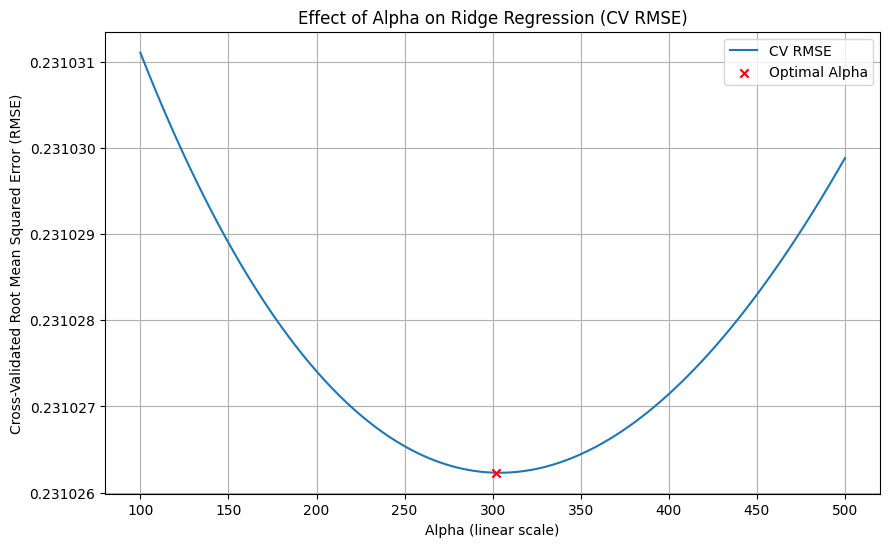

Optimal alpha: 302.0202
Optimal CV score (RMSE): 0.2310
Test RMSE: 0.2274

Intercept: 0.0601

             Feature  Coefficient
               Month       0.0022
         WeekOfMonth      -0.0011
           DayOfWeek       0.0002
                Make      -0.0023
        AccidentArea       0.0051
    DayOfWeekClaimed       0.0011
        MonthClaimed       0.0049
  WeekOfMonthClaimed       0.0003
                 Sex       0.0050
       MaritalStatus       0.0006
                 Age      -0.0112
               Fault      -0.0386
          PolicyType      -0.0080
     VehicleCategory       0.0163
        VehiclePrice      -0.0012
           RepNumber      -0.0024
          Deductible       0.0041
        DriverRating       0.0007
Days:Policy-Accident       0.0031
   Days:Policy-Claim       0.0010
  PastNumberOfClaims      -0.0014
        AgeOfVehicle      -0.0021
   AgeOfPolicyHolder       0.0034
   PoliceReportFiled      -0.0028
      WitnessPresent      -0.0002
           AgentType  

In [ ]:
ridge_car_alpha, ridge_car_cv_score, ridge_car_test_rmse = run_ridge_regression(X_train_car, y_train_car, X_test_car, y_test_car)

## Lasso Regression

In [ ]:
# Your code here
def run_lasso_regression(X_train, y_train, X_test, y_test,
                         log_alphas=np.logspace(0, .02, 100),  # Logarithmic range from 1e-6 to 1e-3
                         lin_alphas=np.linspace(0, .02, 100),
                         log_scale=False,
                         n_jobs = -1
                        ):

    # Define alpha range
    alphas = log_alphas if log_scale else lin_alphas

    # store the rmse scores
    cv_rmse_scores = []

    # Compute cv scores for each alpha
    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        cv_score = -cross_val_score(lasso, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=n_jobs).mean()
        cv_rmse_scores.append(cv_score)

    # Find the optimal alpha
    optimal_index = np.argmin(cv_rmse_scores)
    optimal_alpha = alphas[optimal_index]
    optimal_cv_score = cv_rmse_scores[optimal_index]

    # Train a ridge regression model with the optimal alpha value
    optimal_model = Lasso(alpha=optimal_alpha)
    optimal_model.fit(X_train, y_train)

    # Evaluate on the test dataset
    y_pred = optimal_model.predict(X_test)
    test_rmse = root_mean_squared_error(y_test, y_pred)

    # Plot the msa against the alpha
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, cv_rmse_scores, label="CV RMSE")
    plt.scatter([optimal_alpha], [optimal_cv_score], color='red', marker='x', label='Optimal Alpha', zorder=5)

    # Set scale dynamically based on the log_scale flag
    if log_scale:
        plt.xscale('log')  # Logarithmic scale for alpha
        plt.xlabel('Alpha (log scale)')
    else:
        plt.xlabel('Alpha (linear scale)')

    plt.ylabel('Cross-Validated Root Mean Squared Error (RMSE)')
    plt.title('Effect of Alpha on Lasso Regression (CV RMSE)')
    plt.legend()
    plt.grid()
    plt.ticklabel_format(axis='y', style='plain', useOffset=False)
    plt.show()

    # Print the optimal alpha and its CV score
    print(f"Optimal alpha: {optimal_alpha:.4f}")
    print(f"Optimal CV score (RMSE): {optimal_cv_score:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    
    # Extract coefficients
    coefficients = optimal_model.coef_  # Coefficients for each feature
    intercept = optimal_model.intercept_  # Intercept term


    # Automatically extract feature names from X_train
    feature_names = X_train.columns.tolist()

    coefficients_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": np.around(coefficients,4)
    })

    print(f"\nIntercept: {intercept:.4f}\n")

    print(coefficients_df.to_string(index=False))

    return (optimal_alpha,
            optimal_cv_score, 
            test_rmse)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:1363: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:1363: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:1363: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:1363: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use

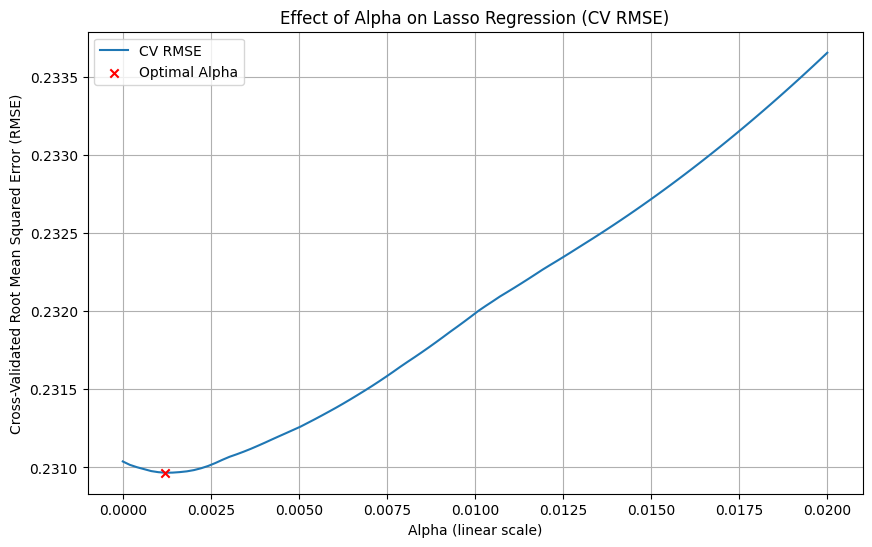

Optimal alpha: 0.0012
Optimal CV score (RMSE): 0.2310
Test RMSE: 0.2276

Intercept: 0.0601

             Feature  Coefficient
               Month       0.0014
         WeekOfMonth      -0.0000
           DayOfWeek       0.0000
                Make      -0.0014
        AccidentArea       0.0041
    DayOfWeekClaimed       0.0000
        MonthClaimed       0.0040
  WeekOfMonthClaimed      -0.0000
                 Sex       0.0038
       MaritalStatus       0.0000
                 Age      -0.0096
               Fault      -0.0381
          PolicyType       0.0000
     VehicleCategory       0.0043
        VehiclePrice      -0.0000
           RepNumber      -0.0012
          Deductible       0.0032
        DriverRating       0.0000
Days:Policy-Accident       0.0025
   Days:Policy-Claim       0.0003
  PastNumberOfClaims      -0.0005
        AgeOfVehicle      -0.0005
   AgeOfPolicyHolder       0.0017
   PoliceReportFiled      -0.0019
      WitnessPresent      -0.0000
           AgentType    

In [ ]:
lasso_car_alpha, lasso_car_cv_score, lasso_car_test_rmse = run_lasso_regression(X_train_car, y_train_car, X_test_car, y_test_car)

## Elastic Net Regression

In [ ]:
def run_elasticnet_CV(X_train, y_train, X_test, y_test):
    
    param_grid = {
        'alpha':    np.linspace(0.1, 10, 100),
        'l1_ratio': np.linspace(0.1, 1, 10)
    }

    elasticnet_cv = GridSearchCV(
        ElasticNet(max_iter=5000, random_state=0),
        param_grid,
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1,
        return_train_score=True
    )
    
    elasticnet_cv.fit(X_train, y_train)

    # Extract results into a DataFrame
    results = pd.DataFrame(elasticnet_cv.cv_results_)
    
    # Select relevant columns for readability
    results = results[[
        'param_alpha',
        'param_l1_ratio',
        'mean_test_score',
        'std_test_score',
        'mean_train_score',
        'std_train_score',
        'rank_test_score'
    ]]

    # Convert negative MSE to positive
    results['mean_test_score'] = -results['mean_test_score']
    results['mean_train_score'] = -results['mean_train_score']

    # Sort by rank (best scores first)
    results = results.sort_values(by='rank_test_score')

    # Rename columns for printing only
    renamed_results = results.rename(
        columns={
            'param_alpha': 'alpha',
            'param_l1_ratio': 'l1_ratio',
            'mean_test_score': 'mean_cv_score',
            'std_test_score': 'std_cv_score',
            'mean_train_score': 'mean_train_score',
            'std_train_score': 'std_train_score'
        }
    ).drop(columns=['rank_test_score'])  # Drop the rank column for readability

    # Print the results as a table
    print("\nSearch Results (Top 5):\n")
    print(renamed_results.head(5).to_string(index=False))  # Show the top 5 results with new headers

    # Best parameters and test performance
    grid_best_params = elasticnet_cv.best_params_
    print(f"\nBest Parameters: {grid_best_params}")
    grid_cv_score = elasticnet_cv.best_score_
    print(f"Best CV RMSE: {grid_cv_score:.4f}")

    # Evaluate on the test set
    y_pred = elasticnet_cv.best_estimator_.predict(X_test)
    test_score = root_mean_squared_error(y_test, y_pred)

    print(f"Test RMSE:    {test_score:.4f}")

    return elasticnet_cv.best_estimator_, {
        'best_params': grid_best_params,
        'best_cv_score': grid_cv_score,
        'test_score': test_score
    }

In [ ]:
elasticnet_car_model, elasticnet_car_results = run_elasticnet_CV(X_train_car, y_train_car, X_test_car, y_test_car)


Search Results (Top 5):

 alpha  l1_ratio  mean_cv_score  std_cv_score  mean_train_score  std_train_score
   0.1       0.1       0.232243      0.004939          0.232243         0.001180
   0.1       0.2       0.233925      0.005131          0.233948         0.001169
   0.2       0.1       0.234218      0.005150          0.234243         0.001177
   0.1       0.3       0.236401      0.005311          0.236424         0.001160
   0.3       0.1       0.236605      0.005301          0.236631         0.001184

Best Parameters: {'alpha': np.float64(0.1), 'l1_ratio': np.float64(0.1)}
Best CV RMSE: -0.2322
Test RMSE:    0.2296


# Insurance Claims dataset

In [ ]:
X_train_ins, X_test_ins, y_train_ins, y_test_ins, df_ins = load_and_split_data("data/insurance_claims_cleaned.csv")

## Ridge Regression

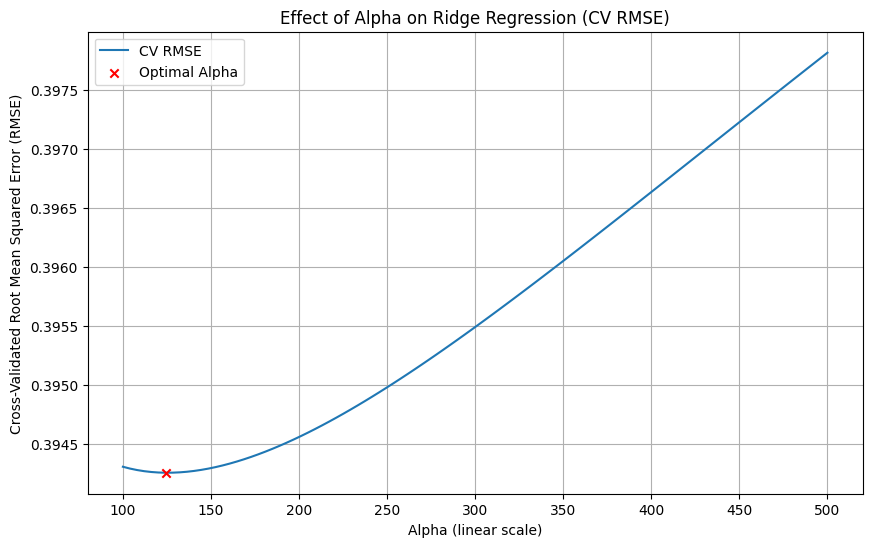

Optimal alpha: 124.2424
Optimal CV score (RMSE): 0.3943
Test RMSE: 0.4176

Intercept: 0.2375

                    Feature  Coefficient
         months_as_customer       0.0038
                        age      -0.0109
               policy_state      -0.0153
                 policy_csl      -0.0174
          policy_deductable      -0.0067
      policy_annual_premium      -0.0189
             umbrella_limit       0.0248
                insured_zip       0.0077
                insured_sex      -0.0094
    insured_education_level       0.0037
         insured_occupation       0.0028
            insured_hobbies       0.0488
       insured_relationship       0.0142
              capital-gains      -0.0084
               capital-loss      -0.0136
              incident_type       0.0005
             collision_type       0.0084
          incident_severity      -0.1426
      authorities_contacted       0.0109
             incident_state      -0.0215
              incident_city      -0.0013
   i

In [ ]:
ridge_ins_alpha, ridge_ins_cv_score, ridge_ins_test_rmse = run_ridge_regression(X_train_ins, y_train_ins, X_test_ins, y_test_ins)

## Lasso Regression

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:1363: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:1363: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularizatio

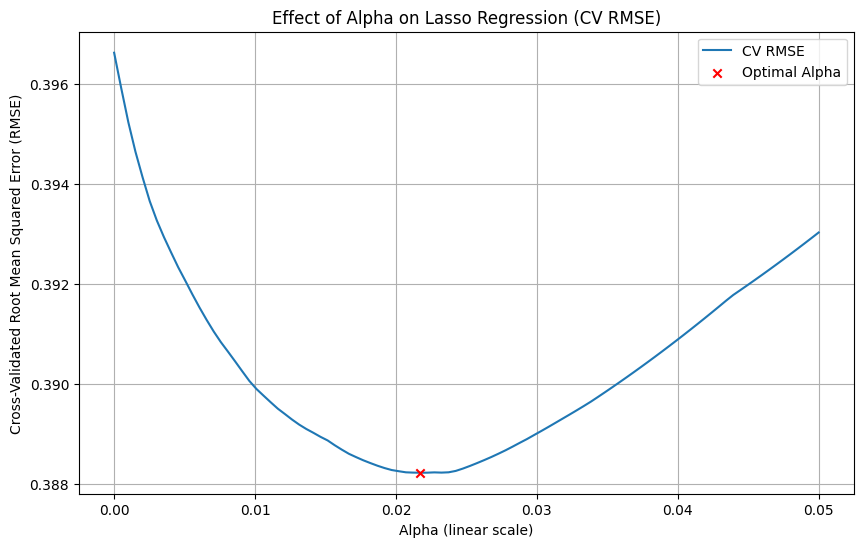

Optimal alpha: 0.0217
Optimal CV score (RMSE): 0.3882
Test RMSE: 0.4125

Intercept: 0.2375

                    Feature  Coefficient
         months_as_customer      -0.0000
                        age      -0.0000
               policy_state      -0.0000
                 policy_csl      -0.0000
          policy_deductable      -0.0000
      policy_annual_premium      -0.0000
             umbrella_limit       0.0057
                insured_zip       0.0000
                insured_sex      -0.0000
    insured_education_level       0.0000
         insured_occupation       0.0000
            insured_hobbies       0.0320
       insured_relationship       0.0000
              capital-gains      -0.0000
               capital-loss      -0.0000
              incident_type      -0.0000
             collision_type       0.0000
          incident_severity      -0.1502
      authorities_contacted       0.0000
             incident_state      -0.0011
              incident_city      -0.0000
   inc

In [ ]:
lasso_ins_alpha, lasso_ins_cv_score, lasso_ins_test_rmse = run_lasso_regression(X_train_ins, y_train_ins, X_test_ins, y_test_ins, lin_alphas=np.linspace(0, .05, 100))

## ElasticNet Regression

In [ ]:
elasticnet_ins_model, elasticnet_ins_results = run_elasticnet_CV(X_train_ins, y_train_ins, X_test_ins, y_test_ins)


Search Results (Top 5):

 alpha  l1_ratio  mean_cv_score  std_cv_score  mean_train_score  std_train_score
   0.1       0.2       0.389146      0.020215          0.386233         0.005538
   0.1       0.3       0.389957      0.019553          0.389043         0.005464
   0.1       0.1       0.390330      0.021148          0.381389         0.005804
   0.2       0.1       0.390445      0.019538          0.387584         0.005444
   0.1       0.4       0.391790      0.018963          0.390950         0.005373

Best Parameters: {'alpha': np.float64(0.1), 'l1_ratio': np.float64(0.2)}
Best CV RMSE: -0.3891
Test RMSE:    0.4137


In [ ]:
# DataFrame of the results
results_df = pd.DataFrame([
    {
        "Dataset": "Car Claims",
        "Model": "Ridge",
        "Alpha": ridge_car_alpha,
        "L1 Ratio": None,
        "Best CV RMSE": ridge_car_cv_score,
        "Test RMSE": ridge_car_test_rmse,
        "Best Params": {"alpha": ridge_car_alpha}
    },
    {
        "Dataset": "Car Claims",
        "Model": "Lasso",
        "Alpha": lasso_car_alpha,
        "L1 Ratio": None,
        "Best CV RMSE": lasso_car_cv_score,
        "Test RMSE": lasso_car_test_rmse,
        "Best Params": {"alpha": lasso_car_alpha}
    },
    {
        "Dataset": "Car Claims",
        "Model": "ElasticNet",
        "Alpha": elasticnet_car_results['best_params']['alpha'],
        "L1 Ratio": elasticnet_car_results['best_params']['l1_ratio'],
        "Best CV RMSE": -elasticnet_car_results['best_cv_score'],
        "Test RMSE": elasticnet_car_results['test_score'],
        "Best Params": elasticnet_car_results['best_params']
    },
    {
        "Dataset": "Insurance Claims",
        "Model": "Ridge",
        "Alpha": ridge_ins_alpha,
        "L1 Ratio": None,
        "Best CV RMSE": ridge_ins_cv_score,
        "Test RMSE": ridge_ins_test_rmse,
        "Best Params": {"alpha": ridge_ins_alpha}
    },
    {
        "Dataset": "Insurance Claims",
        "Model": "Lasso",
        "Alpha": lasso_ins_alpha,
        "L1 Ratio": None,
        "Best CV RMSE": lasso_ins_cv_score,
        "Test RMSE": lasso_ins_test_rmse,
        "Best Params": {"alpha": lasso_ins_alpha}
    },
    {
        "Dataset": "Insurance Claims",
        "Model": "ElasticNet",
        "Alpha": elasticnet_ins_results['best_params']['alpha'],
        "L1 Ratio": elasticnet_ins_results['best_params']['l1_ratio'],
        "Best CV RMSE": -elasticnet_ins_results['best_cv_score'],
        "Test RMSE": elasticnet_ins_results['test_score'],
        "Best Params": elasticnet_ins_results['best_params']
    }
])

display(results_df)

,Dataset,Model,Alpha,L1 Ratio,Best CV RMSE,Test RMSE,Best Params
0,Car Claims,Ridge,302.020202,NaN,0.231026,0.227435,{'alpha': 302.020202020202}
1,Car Claims,Lasso,0.001212,NaN,0.230966,0.227586,{'alpha': 0.0012121212121212121}
2,Car Claims,ElasticNet,0.100000,0.1,0.232243,0.229593,"{'alpha': 0.1, 'l1_ratio': 0.1}"
3,Insurance Claims,Ridge,124.242424,NaN,0.394253,0.417624,{'alpha': 124.24242424242425}
4,Insurance Claims,Lasso,0.021717,NaN,0.388222,0.412453,{'alpha': 0.021717171717171718}
5,Insurance Claims,ElasticNet,0.100000,0.2,0.389146,0.413742,"{'alpha': 0.1, 'l1_ratio': 0.2}"
